## Assessing impact of various DL tricks (vis Regularisation) on finetuned resnet50 model performance

Adding dropout to pytorch models: https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models/  
L1/L2 Regularisation: https://python-code.dev/articles/242716633

First download V4 dataset:

In [1]:
# check metadata csv file (dataset-v4.csv) is in google drive

# mount google drive
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

# peek contents of dataset-v4.csv
!head /content/drive/MyDrive/team_challenge/dataset-v4.csv

Mounted at /content/drive
,annotation_id,annotator,choice,created_at,id,image,lead_time,updated_at,labels,subset
0,4024,10,Clover,2024-07-16T12:15:40.960299Z,87231,OV3XXX_1_582_970.jpg,5.152,2024-07-16T12:15:40.960318Z,['Clover'],Train
1,19621,1,"{""choices"":[""Grass"",""Dung""]}",2024-07-26T17:43:59.440503Z,52689,Cow Dung_Livia_378_582_194.jpg,1.443,2024-07-26T17:43:59.440522Z,"['Grass', 'Dung']",Train
2,16876,3,"{""choices"":[""Clover"",""Grass""]}",2024-07-23T10:57:48.626335Z,50010,Clover_Stev_348_1552_776.jpg,1.23,2024-07-23T10:57:48.626352Z,"['Clover', 'Grass']",Train
3,14621,5,"{""choices"":[""Grass"",""Soil""]}",2024-07-18T16:26:16.223214Z,19317,Bare Soil_Maxwell_16_388_582.jpg,1.345,2024-07-18T16:26:16.223233Z,"['Grass', 'Soil']",Train
4,12780,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T16:51:30.637064Z,113179,More Clover_13_1312_1164.jpg,1.319,2024-07-17T16:51:30.637082Z,"['Clover', 'Grass']",Train
5,16603,5,"{""choices"":[""Grass"",""Dung""]}",2024-07-22T17:32:48.379

In [6]:
# Generate df and perform processing

import pandas as pd

csv_path = "/content/drive/MyDrive/team_challenge/dataset-v4.csv"
main_df = pd.read_csv(csv_path)
main_df['image_name'] = main_df['image']
# main_df['image_name'] = main_df['image'].apply(lambda x: x.split('/')[-1].replace('%20', ' ')) # Ensure URL encoded spaces are replaced
main_df_noNaN = main_df.dropna(subset=['labels'])

print(f"{len(main_df) - len(main_df_noNaN)} images with no labels removed")

main_df

0 images with no labels removed


,Unnamed: 0,annotation_id,annotator,choice,created_at,id,image,lead_time,updated_at,labels,subset,image_name
0,0,4024,10,Clover,2024-07-16T12:15:40.960299Z,87231,OV3XXX_1_582_970.jpg,5.152,2024-07-16T12:15:40.960318Z,['Clover'],Train,OV3XXX_1_582_970.jpg
1,1,19621,1,"{""choices"":[""Grass"",""Dung""]}",2024-07-26T17:43:59.440503Z,52689,Cow Dung_Livia_378_582_194.jpg,1.443,2024-07-26T17:43:59.440522Z,"['Grass', 'Dung']",Train,Cow Dung_Livia_378_582_194.jpg
2,2,16876,3,"{""choices"":[""Clover"",""Grass""]}",2024-07-23T10:57:48.626335Z,50010,Clover_Stev_348_1552_776.jpg,1.230,2024-07-23T10:57:48.626352Z,"['Clover', 'Grass']",Train,Clover_Stev_348_1552_776.jpg
3,3,14621,5,"{""choices"":[""Grass"",""Soil""]}",2024-07-18T16:26:16.223214Z,19317,Bare Soil_Maxwell_16_388_582.jpg,1.345,2024-07-18T16:26:16.223233Z,"['Grass', 'Soil']",Train,Bare Soil_Maxwell_16_388_582.jpg
4,4,12780,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T16:51:30.637064Z,113179,More Clover_13_1312_1164.jpg,1.319,2024-07-17T16:51:30.637082Z,"['Clover', 'Grass']",Train,More Clover_13_1312_1164.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
2886,2886,189,3,"{""choices"":[""Grass"",""Dung""]}",2024-07-11T10:03:33.844396Z,93550,Sheep Dung_Livia_837_582_388.jpg,4.678,2024-07-11T10:03:33.844426Z,"['Grass', 'Dung']",Train,Sheep Dung_Livia_837_582_388.jpg
2887,2887,13617,12,"{""choices"":[""Grass"",""Dung""]}",2024-07-18T09:19:45.344062Z,57523,Cow Dung_Stev_432_1312_1164.jpg,852.126,2024-07-18T09:19:45.344080Z,"['Grass', 'Dung']",Train,Cow Dung_Stev_432_1312_1164.jpg
2888,2888,11880,12,"{""choices"":[""Grass"",""Dung""]}",2024-07-17T15:19:44.796236Z,55015,Cow Dung_Livia_405_1164_0.jpg,1.928,2024-07-17T15:19:44.796254Z,"['Grass', 'Dung']",Train,Cow Dung_Livia_405_1164_0.jpg
2889,2889,2284,2,"{""choices"":[""Grass"",""Dung""]}",2024-07-14T13:03:38.691054Z,51060,Cow Dung_Fran_359_970_388.jpg,1.478,2024-07-14T13:03:38.691072Z,"['Grass', 'Dung']",Val,Cow Dung_Fran_359_970_388.jpg


In [7]:
# Download images zips
!wget https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/data.zip

--2024-08-12 13:49:54--  https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/data.zip
Resolving sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (sensor-cdt-group-project.s3.eu-north-1.amazonaws.com)... 3.5.217.57, 3.5.218.63
Connecting to sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (sensor-cdt-group-project.s3.eu-north-1.amazonaws.com)|3.5.217.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1779842156 (1.7G) [binary/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.66G  17.7MB/s    in 1m 53s  

2024-08-12 13:51:48 (15.0 MB/s) - ‘data.zip’ saved [1779842156/1779842156]



In [8]:
# Make dir to store images & unzip
!mkdir -p finetune_data
!unzip -q data.zip -d finetune_data

Prepare pretrained resnet50

In [9]:
# Functions for preparing a multilabel resnet model

import torch
from torchvision.models import resnet50, ResNet50_Weights

def load_ResNet_model():
  # return resnet50(pretrained=True)
  return resnet50(weights=ResNet50_Weights.DEFAULT) # best available weights (https://pytorch.org/vision/stable/models.html)

# Define a new class to wrap the model with a sigmoid activation
class MultiLabelResNet(torch.nn.Module):
    def __init__(self, original_model, num_classes):
        super(MultiLabelResNet, self).__init__()
        self.resnet = original_model
        self.resnet.fc = torch.nn.Linear(in_features=2048, out_features=num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        x = self.sigmoid(x)
        return x

In [10]:
# Create model for finetuning

new_num_classes = 4 # {Grass, Clover, Soil, Dung}

ResNet_model = load_ResNet_model()
ResNet_model = MultiLabelResNet(ResNet_model, new_num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 65.3MB/s]


Finetuning resnet model (no dropout)

In [11]:
# Prepare dataset class and transform

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import v2 # NB using v2 this time
import os
import ast
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
        def __init__(self, dataframe, img_dir, transform=None):
            self.dataframe = dataframe
            self.img_dir = img_dir
            self.transform = transform
            self.label_map = {'Grass': 0, 'Clover': 1, 'Soil': 2, 'Dung': 3} # NB 4 classes
            self.num_classes = len(self.label_map)
            self.class_names = list(self.label_map.keys())
            self.image_paths = [os.path.join(self.img_dir, img_name) for img_name in self.dataframe.iloc[:, 6]]

        def __len__(self):
            return len(self.dataframe)

        def __getitem__(self, idx):
            img_name = self.image_paths[idx]
            image = Image.open(img_name).convert("RGB")

            # Extract and process the label string
            label_str = self.dataframe.iloc[idx, 9]
            label_list = ast.literal_eval(label_str)  # Safely evaluate the string to a list
            label_indices = [self.label_map[label] for label in label_list]  # Map to indices
            label_tensor = torch.tensor(label_indices, dtype=torch.long)

            label_onehot = nn.functional.one_hot(label_tensor, num_classes=self.num_classes)
            label_onehot = label_onehot.max(dim=0)[0].float()

            if self.transform:
                image = self.transform(image)

            return image, label_onehot

        def get_image_path(self, idx):
            return self.image_paths[idx]

        def get_labels(self, idx):
            return self.dataframe.iloc[idx, 9]

transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:
# Prepare dataloaders

img_dir = 'finetune_data/'

train_df = main_df[main_df['subset'] == 'Train']
val_df = main_df[main_df['subset'] == 'Val']

train_dataset = CustomDataset(dataframe=train_df, img_dir=img_dir, transform=transform)
val_dataset = CustomDataset(dataframe=val_df, img_dir=img_dir, transform=transform)

label_map = train_dataset.label_map

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Train set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')

Train set size: 2290
Validation set size: 601


In [13]:
!pip -q install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 46.6 MB/s eta 0:00:00


In [14]:
import torch
import keras
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
from torchmetrics.classification import MultilabelF1Score

def fine_tune_model(model, device, train_loader, val_loader, optimiser, loss_function, num_epochs=20, patience=5):

    ''' Inspired by https://keras.io/guides/writing_a_custom_training_loop_in_torch/ '''

    start = time.time()

    # Use keras function for computing accuracy
    # NB labels are one-hot encoded
    # NBB BinaryAccuracy rather than Categorical (less harsh)
    train_acc_metric = keras.metrics.BinaryAccuracy()
    val_acc_metric = keras.metrics.BinaryAccuracy()

    # Move F1 metrics to the correct device
    train_f1_metric = MultilabelF1Score(num_labels=new_num_classes).to(device)
    val_f1_metric = MultilabelF1Score(num_labels=new_num_classes).to(device)

    # lists to store loss/accuracy tuples of each epoch
    epoch_train_stats = []
    epoch_val_stats = []

    best_val_f1 = 0.0
    epochs_no_improve = 0
    best_model_weights = None

    # Initial evaluation before fine-tuning
    def evaluate_model(model, data_loader, loss_function, acc_metric, f1_metric):
        model.eval()
        running_loss = 0.0
        num_batches = 0
        with torch.no_grad():
            for inputs, targets in tqdm(data_loader, leave=False):
                inputs = inputs.to(device)
                targets = targets.to(device)

                logits = model(inputs)
                loss = loss_function(logits, targets)

                acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())
                f1_metric.update(logits, targets)

                running_loss += loss.item()
                num_batches += 1

        epoch_loss = running_loss / num_batches
        epoch_acc = acc_metric.result().numpy()  # Convert to numpy
        epoch_f1 = f1_metric.compute().item()  # Convert to scalar
        f1_metric.reset()
        acc_metric.reset_state()

        return epoch_loss, epoch_acc, epoch_f1

    # Evaluate model on training and validation datasets before training
    initial_train_loss, initial_train_acc, initial_train_f1 = evaluate_model(model, train_loader, loss_function, train_acc_metric, train_f1_metric)
    epoch_train_stats.append((initial_train_loss, initial_train_acc, initial_train_f1))

    initial_val_loss, initial_val_acc, initial_val_f1 = evaluate_model(model, val_loader, loss_function, val_acc_metric, val_f1_metric)
    epoch_val_stats.append((initial_val_loss, initial_val_acc, initial_val_f1))

    print(f'Initial Train loss: {initial_train_loss:.2f}, Train accuracy: {initial_train_acc:.2f}, Train f1: {initial_train_f1:.2f} '
          f'Val loss: {initial_val_loss:.2f}, Val accuracy: {initial_val_acc:.2f}, Val f1: {initial_val_f1:.2f}')

    for epoch in range(num_epochs):

        print(f"epoch {epoch+1}/{num_epochs}")

        # Set model to training mode
        model.train()

        running_loss = 0.0
        num_batches = 0

        for inputs, targets in tqdm(train_loader, leave=False):

            inputs = inputs.to(device)  # Assuming 'device' is properly set
            targets = targets.to(device)

            optimiser.zero_grad()

            # Forward pass
            logits = model(inputs)
            loss = loss_function(logits, targets)

            # Backward pass
            loss.backward()

            # Optimiser variable updates
            optimiser.step()

            # Update training metric
            train_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())
            train_f1_metric.update(logits, targets)

            # Increment loss & batch count
            running_loss += loss.item()
            num_batches += 1

        # Get train loss & accuracy for the epoch
        train_epoch_loss = running_loss / num_batches
        train_epoch_acc = train_acc_metric.result().numpy()  # Convert to numpy
        train_epoch_f1 = train_f1_metric.compute().item()  # Convert to scalar
        epoch_train_stats.append((train_epoch_loss,train_epoch_acc, train_epoch_f1))

        # Run a validation loop at the end of each epoch
        model.eval()
        val_running_loss = 0.0
        val_num_batches = 0

        with torch.no_grad():
            for x_batch_val, y_batch_val in tqdm(val_loader, leave=False):
                x_batch_val = x_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)

                # Forward pass
                val_logits = model(x_batch_val)
                val_loss = loss_function(val_logits, y_batch_val)

                # Update validation metrics
                val_acc_metric.update_state(y_batch_val.cpu().detach().numpy(), val_logits.cpu().detach().numpy())
                val_f1_metric.update(val_logits, y_batch_val)

                # Increment validation loss & batch count
                val_running_loss += val_loss.item()
                val_num_batches += 1

        # Get val loss & accuracy for the epoch
        val_epoch_loss = val_running_loss / val_num_batches
        val_epoch_acc = val_acc_metric.result().numpy()  # Convert to numpy
        val_epoch_f1 = val_f1_metric.compute().item()  # Convert to scalar

        epoch_val_stats.append((val_epoch_loss, val_epoch_acc, val_epoch_f1))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
        train_f1_metric.reset()
        val_f1_metric.reset()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train loss: {train_epoch_loss:.2f}, Train accuracy: {train_epoch_acc:.2f}, Train f1: {train_epoch_f1:.2f}, Val loss: {val_epoch_loss:.2f}, Val accuracy: {val_epoch_acc:.2f}, Val f1: {val_epoch_f1:.2f}')

        # Check for early stopping based on validation accuracy
        if val_epoch_f1 > best_val_f1:
            best_val_f1 = val_epoch_f1
            epochs_no_improve = 0
            best_model_weights = model.state_dict().copy()
            print(f"Best model saved with f1: {best_val_f1:.2f}")
        else:
            epochs_no_improve += 1
            print(f"Validation f1 not improved {epochs_no_improve} times.")

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

    # Load the best model weights after training
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print("Loaded the best model weights.")

    elapsed_time = time.time() - start
    print('Fine-tuning complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

    return model, epoch_train_stats, epoch_val_stats


In [15]:
# Finetune model

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define loss function and optimiser
loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
optimiser = optim.Adam(ResNet_model.parameters(), lr=0.0001)  # Adjust learning rate as needed

ResNet_model.to(device) # Detect if GPU is available

# Fine-tune the model
ResNet_model, ResNet_train_stats, ResNet_val_stats = fine_tune_model(model        = ResNet_model,
                                                                    device        = device,
                                                                    train_loader  = train_loader,
                                                                    val_loader    = val_loader,
                                                                    optimiser     = optimiser,
                                                                    loss_function = loss_function,
                                                                    num_epochs    = 10)

Initial Train loss: 0.71, Train accuracy: 0.52, Train f1: 0.28 Val loss: 0.72, Val accuracy: 0.51, Val f1: 0.28
epoch 1/10


Epoch [1/10], Train loss: 0.40, Train accuracy: 0.84, Train f1: 0.79, Val loss: 0.23, Val accuracy: 0.91, Val f1: 0.89
Best model saved with f1: 0.89
epoch 2/10


Epoch [2/10], Train loss: 0.19, Train accuracy: 0.93, Train f1: 0.92, Val loss: 0.19, Val accuracy: 0.93, Val f1: 0.92
Best model saved with f1: 0.92
epoch 3/10


Epoch [3/10], Train loss: 0.11, Train accuracy: 0.96, Train f1: 0.95, Val loss: 0.17, Val accuracy: 0.94, Val f1: 0.93
Best model saved with f1: 0.93
epoch 4/10


Epoch [4/10], Train loss: 0.07, Train accuracy: 0.98, Train f1: 0.97, Val loss: 0.19, Val accuracy: 0.93, Val f1: 0.92
Validation f1 not improved 1 times.
epoch 5/10


Epoch [5/10], Train loss: 0.06, Train accuracy: 0.98, Train f1: 0.98, Val loss: 0.20, Val accuracy: 0.93, Val f1: 0.92
Validation f1 not improved 2 times.
epoch 6/10


Epoch [6/10], Train loss: 0.04, Train accuracy: 0.99, Train f1: 0.98, Val loss: 0.21, Val accuracy: 0.93, Val f1: 0.92
Validation f1 not improved 3 times.
epoch 7/10


Epoch [7/10], Train loss: 0.03, Train accuracy: 0.99, Train f1: 0.99, Val loss: 0.20, Val accuracy: 0.93, Val f1: 0.92
Validation f1 not improved 4 times.
epoch 8/10


Epoch [8/10], Train loss: 0.02, Train accuracy: 0.99, Train f1: 0.99, Val loss: 0.21, Val accuracy: 0.93, Val f1: 0.92
Validation f1 not improved 5 times.
Early stopping triggered after 8 epochs
Loaded the best model weights.
Fine-tuning complete in 4m 41s


In [16]:
# Save the model
torch.save(ResNet_model.state_dict(), '/content/drive/MyDrive/team_challenge/240812_rawResNet.pth')

In [17]:
# function for plotting training history

import matplotlib.pyplot as plt

def plot_training_history(train_stats, val_stats, title):

  epochs = range(1, len(train_stats) + 1)
  train_losses = [entry[0] for entry in train_stats]
  train_accuracies = [entry[1] for entry in train_stats]
  val_losses = [entry[0] for entry in val_stats]
  val_accuracies = [entry[1] for entry in val_stats]

  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

  fig.suptitle(title)

  train_colour = 'tab:blue'
  val_colour = 'tab:red'
  # Plotting loss
  ax1.plot(epochs, train_losses, label='Train Loss', color=train_colour)
  ax1.plot(epochs, val_losses, label='Val Loss', color=val_colour)
  ax1.set_ylabel('Loss')
  ax1.legend()

  # Plot accuracy
  ax2.plot(epochs, train_accuracies, label='Train Accuracy', color=train_colour)
  ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=val_colour)
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.tight_layout()
  return plt.show()

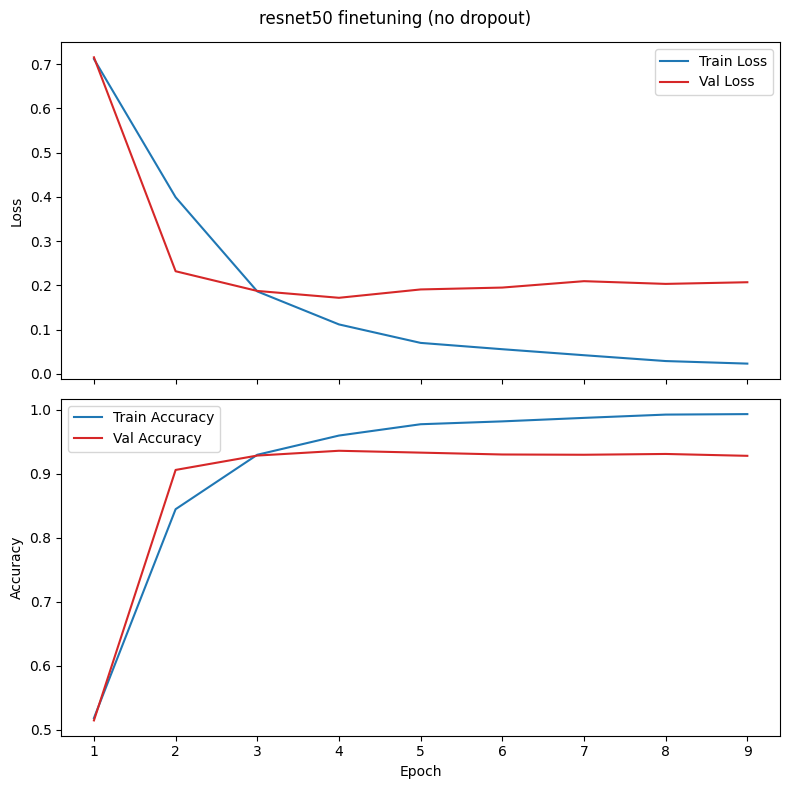

In [18]:
plot_training_history(ResNet_train_stats, ResNet_val_stats, "resnet50 finetuning (no dropout)")

Evaluate raw ResNet model

In [19]:
# Make true labels array of val set

import numpy as np

true_labels = []
for _, labels in val_loader:
  true_labels.append(labels.numpy())
true_labels = np.vstack(true_labels)

In [20]:
# Evaulate model on test set (inference)

from tqdm import tqdm
import numpy as np

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ResNet_model.to(device)

ResNet_model.eval()

raw_ResNet_predictions = []

with torch.no_grad():
  for data in tqdm(val_dataset):
      inputs, labels = data
      inputs = inputs.unsqueeze(0).to(device)   # Add batch dimension and move to device

      output = ResNet_model(inputs)
      predictions = (output > 0.5).float()      # Threshold value of 0.5

      raw_ResNet_predictions.append(predictions.cpu().detach().numpy())

raw_ResNet_predictions = np.squeeze(np.array(raw_ResNet_predictions), axis=1)

100%|██████████| 601/601 [00:06<00:00, 90.10it/s]


In [21]:
# Accuracy metrics for raw ResNet predictions

from sklearn.metrics import accuracy_score
from keras.metrics import BinaryAccuracy

sklearn_acc = accuracy_score(true_labels, raw_ResNet_predictions)

keras_bin_acc = BinaryAccuracy()
keras_bin_acc.update_state(true_labels, raw_ResNet_predictions)

print("Accuracy of raw ResNet model:")
print(f"sklearn = {sklearn_acc}")
print(f"keras binary = {keras_bin_acc.result()}")

keras_bin_acc.reset_state()

Accuracy of raw ResNet model:
sklearn = 0.7870216306156406
keras binary = 0.928036630153656


In [22]:
# Function for plotting confusion matrices

import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

def show_confusion(true_labels, label_map, val_predictions):

    class_names = [label for label in label_map.keys()]

    confusion_matrices = multilabel_confusion_matrix(true_labels, val_predictions)

    num_classes = len(class_names)
    grid_size = int(np.ceil(np.sqrt(num_classes)))

    fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(10, 10))

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Plot each confusion matrix
    for i, (confusion_matrix, class_name) in enumerate(zip(confusion_matrices, class_names)):
        ax = axes[i]
        im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(class_name)

        # Show all ticks and label them with the respective list entries
        ax.set(xticks=np.arange(confusion_matrix.shape[1]),
            yticks=np.arange(confusion_matrix.shape[0]),
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            ylabel='True label',
            xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = 'd'
        thresh = confusion_matrix.max() / 2.
        for j in range(confusion_matrix.shape[0]):
            for k in range(confusion_matrix.shape[1]):
                ax.text(k, j, format(confusion_matrix[j, k], fmt),
                        ha="center", va="center",
                        color="white" if confusion_matrix[j, k] > thresh else "black")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Plot normalised confusion matrices

    fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(15, 15))

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Plot each confusion matrix
    for i, (confusion_matrix, class_name) in enumerate(zip(confusion_matrices, class_names)):
        ax = axes[i]

        # Normalize the confusion matrix
        cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

        # Calculate rates
        TP = confusion_matrix[1, 1]
        TN = confusion_matrix[0, 0]
        FP = confusion_matrix[0, 1]
        FN = confusion_matrix[1, 0]
        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  # True Positive Rate
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0  # False Positive Rate
        TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  # True Negative Rate
        FNR = FN / (FN + TP) if (FN + TP) != 0 else 0  # False Negative Rate

        im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f"{class_name}\nTPR: {TPR:.2f}, FPR: {FPR:.2f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")

        # Show all ticks and label them with the respective list entries
        ax.set(xticks=np.arange(confusion_matrix.shape[1]),
            yticks=np.arange(confusion_matrix.shape[0]),
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            ylabel='True label',
            xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f'
        thresh = cm_normalized.max() / 2.
        for j in range(cm_normalized.shape[0]):
            for k in range(cm_normalized.shape[1]):
                ax.text(k, j, format(cm_normalized[j, k], fmt),
                        ha="center", va="center",
                        color="white" if cm_normalized[j, k] > thresh else "black")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

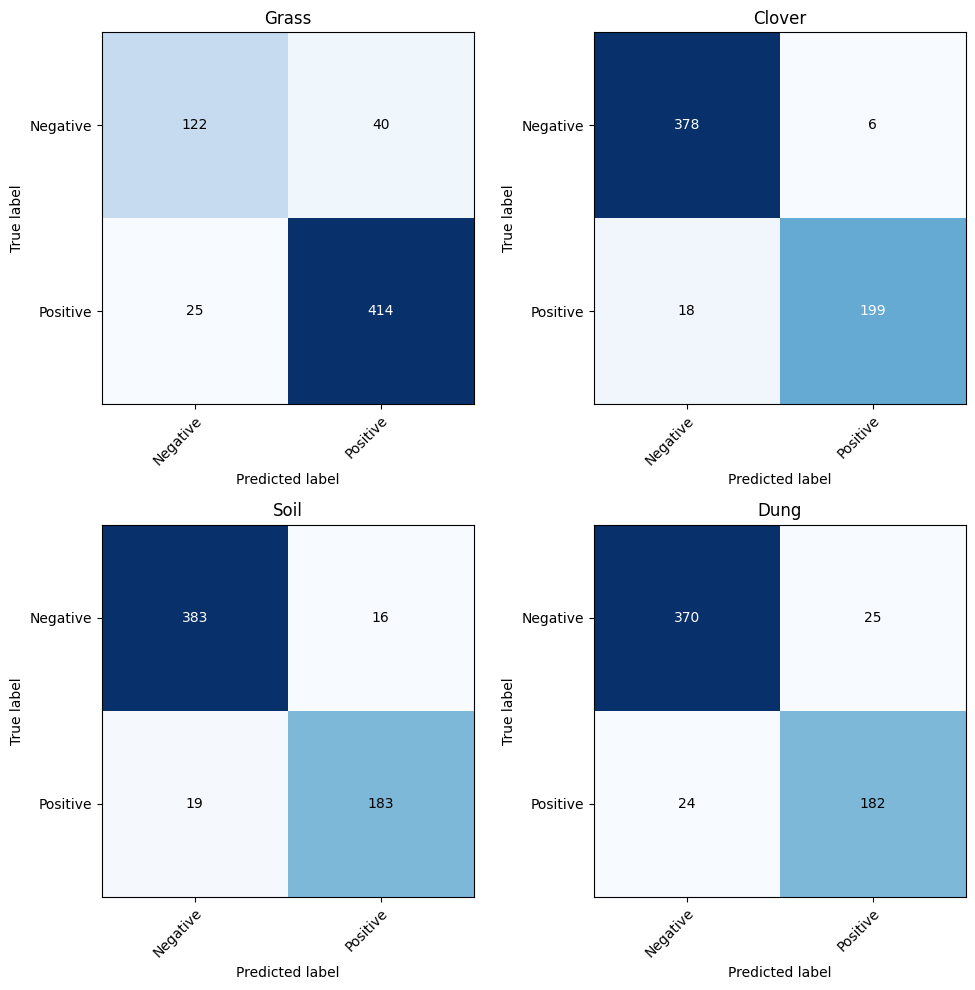

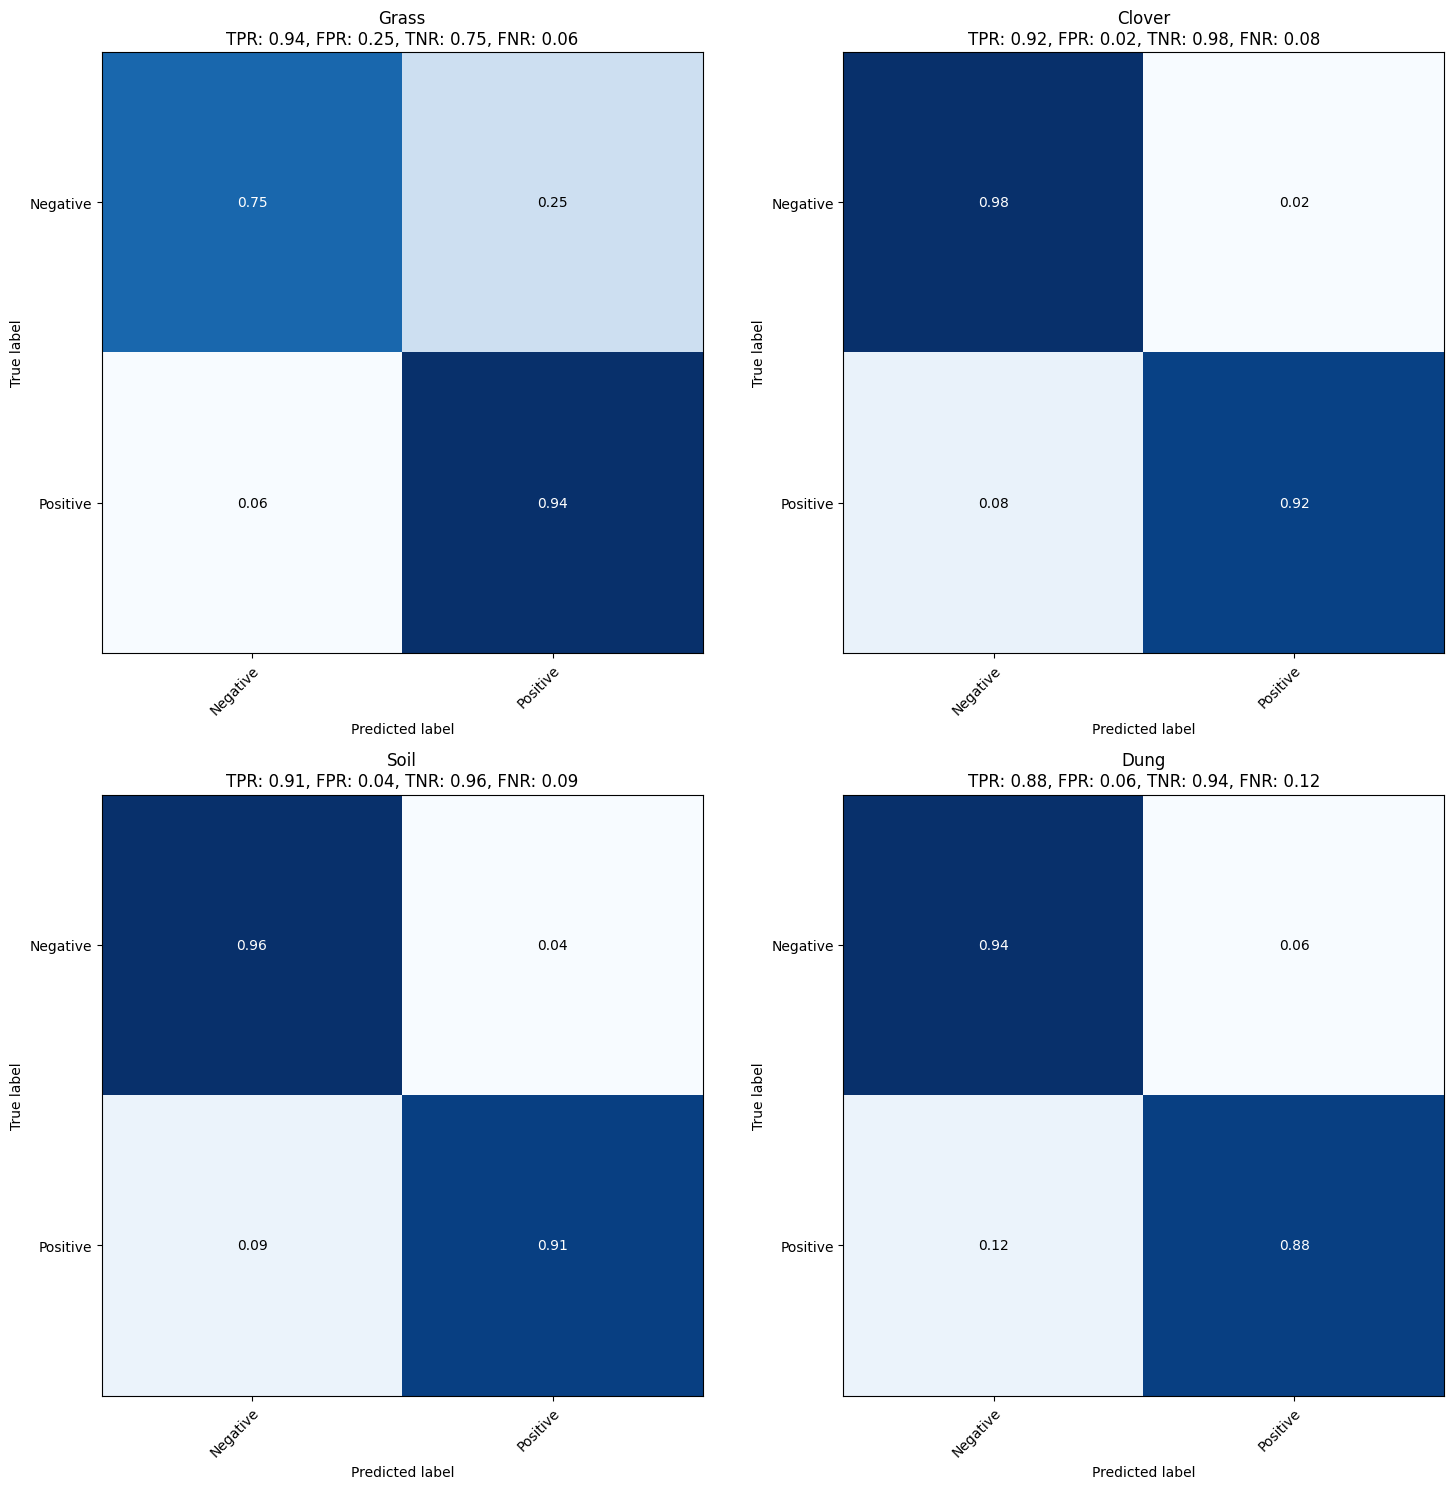

In [23]:
# Confusion matrices for raw resnet model

show_confusion(true_labels, label_map, raw_ResNet_predictions)

Make model with dropout & finetune

In [31]:
# Function for adding dropout to the model

import torch.nn as nn

# def add_dropout(model, rate=0.2):

#   ''' Taken from https://discuss.pytorch.org/t/where-and-how-to-add-dropout-in-resnet18/12869 '''

#   for name, module in model.named_children():

#       if len(list(module.children())) > 0:
#           add_dropout(module)
#       if isinstance(module, nn.ReLU):
#           new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=True))
#           setattr(model, name, new)

import torch.nn as nn

def add_dropout(model, rate=0.2):

    ''' Taken from https://discuss.pytorch.org/t/where-and-how-to-add-dropout-in-resnet18/12869 '''

    for name, module in model.named_children():
        # Recursively add dropout to children modules
        if len(list(module.children())) > 0:
            add_dropout(module, rate=rate)  # Pass the rate parameter

        # Replace ReLU with a Sequential containing ReLU and Dropout2d
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))  # Changed inplace to False
            setattr(model, name, new)  # Replace the module in the model with the new one



In [32]:
# Create new model & add dropout

dropout20_ResNet_model = load_ResNet_model()

dropout20_ResNet_model = MultiLabelResNet(dropout20_ResNet_model, new_num_classes)

add_dropout(dropout20_ResNet_model, rate=0.2)

print(dropout20_ResNet_model)

MultiLabelResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): Sequential(
      (0): ReLU(inplace=True)
      (1): Dropout2d(p=0.2, inplace=False)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [33]:
# finetune model with dropout

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define loss function and optimiser
loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
optimiser = optim.Adam(dropout20_ResNet_model.parameters(), lr=0.0001)  # Adjust learning rate as needed

dropout20_ResNet_model.to(device) # Detect if GPU is available

# Fine-tune the model
dropout20_ResNet_model, dropout20_train_stats, dropout20_val_stats = fine_tune_model(model        = dropout20_ResNet_model,
                                                                    device        = device,
                                                                    train_loader  = train_loader,
                                                                    val_loader    = val_loader,
                                                                    optimiser     = optimiser,
                                                                    loss_function = loss_function,
                                                                    num_epochs    = 10)

Initial Train loss: 0.69, Train accuracy: 0.55, Train f1: 0.31 Val loss: 0.69, Val accuracy: 0.55, Val f1: 0.31
epoch 1/10


Epoch [1/10], Train loss: 0.67, Train accuracy: 0.60, Train f1: 0.39, Val loss: 0.69, Val accuracy: 0.59, Val f1: 0.34
Best model saved with f1: 0.34
epoch 2/10


Epoch [2/10], Train loss: 0.65, Train accuracy: 0.65, Train f1: 0.32, Val loss: 0.69, Val accuracy: 0.68, Val f1: 0.24
Validation f1 not improved 1 times.
epoch 3/10


Epoch [3/10], Train loss: 0.64, Train accuracy: 0.66, Train f1: 0.28, Val loss: 0.69, Val accuracy: 0.67, Val f1: 0.21
Validation f1 not improved 2 times.
epoch 4/10


Epoch [4/10], Train loss: 0.64, Train accuracy: 0.67, Train f1: 0.28, Val loss: 0.69, Val accuracy: 0.71, Val f1: 0.36
Best model saved with f1: 0.36
epoch 5/10


Epoch [5/10], Train loss: 0.63, Train accuracy: 0.67, Train f1: 0.28, Val loss: 0.68, Val accuracy: 0.67, Val f1: 0.21
Validation f1 not improved 1 times.
epoch 6/10


Epoch [6/10], Train loss: 0.63, Train accuracy: 0.67, Train f1: 0.27, Val loss: 0.68, Val accuracy: 0.67, Val f1: 0.21
Validation f1 not improved 2 times.
epoch 7/10


Epoch [7/10], Train loss: 0.63, Train accuracy: 0.67, Train f1: 0.28, Val loss: 0.68, Val accuracy: 0.67, Val f1: 0.21
Validation f1 not improved 3 times.
epoch 8/10


Epoch [8/10], Train loss: 0.63, Train accuracy: 0.67, Train f1: 0.28, Val loss: 0.67, Val accuracy: 0.67, Val f1: 0.21
Validation f1 not improved 4 times.
epoch 9/10


Epoch [9/10], Train loss: 0.62, Train accuracy: 0.67, Train f1: 0.29, Val loss: 0.67, Val accuracy: 0.67, Val f1: 0.21
Validation f1 not improved 5 times.
Early stopping triggered after 9 epochs
Loaded the best model weights.
Fine-tuning complete in 5m 20s


In [34]:
# Save the model
torch.save(dropout20_ResNet_model.state_dict(), '/content/drive/MyDrive/team_challenge/240812_dropout20_ResNet.pth')

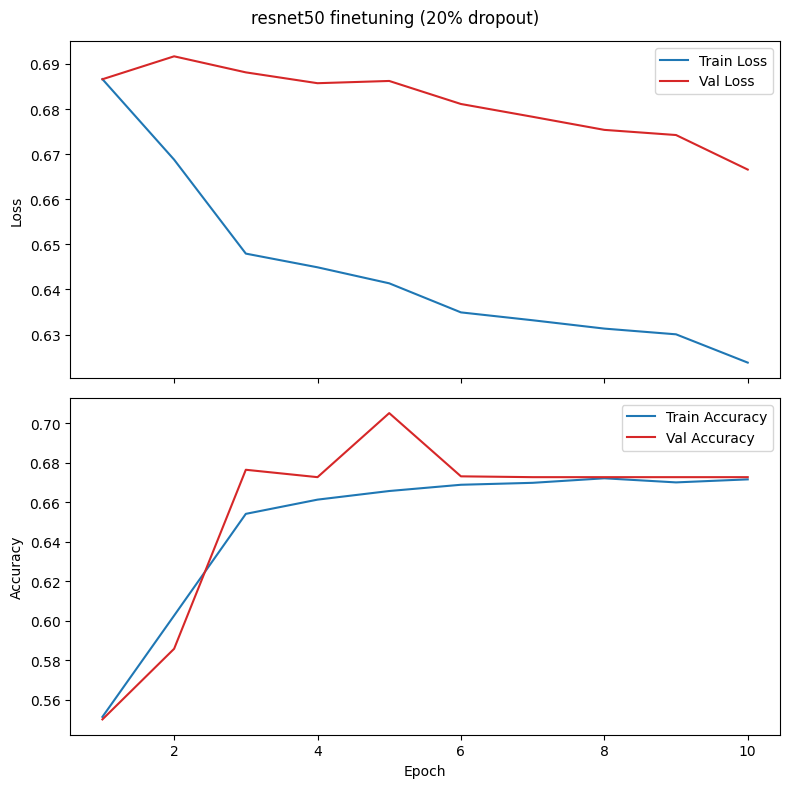

In [35]:
plot_training_history(dropout20_train_stats, dropout20_val_stats, "resnet50 finetuning (20% dropout)")

In [36]:
# Evaulate model on test set (inference)

from tqdm import tqdm
import numpy as np

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dropout20_ResNet_model.to(device)

dropout20_ResNet_model.eval()

dropout20_ResNet_predictions = []

with torch.no_grad():
  for data in tqdm(val_dataset):
      inputs, labels = data
      inputs = inputs.unsqueeze(0).to(device)   # Add batch dimension and move to device

      output = dropout20_ResNet_model(inputs)
      predictions = (output > 0.5).float()      # Threshold value of 0.5

      dropout20_ResNet_predictions.append(predictions.cpu().detach().numpy())

dropout20_ResNet_predictions = np.squeeze(np.array(dropout20_ResNet_predictions), axis=1)

100%|██████████| 601/601 [00:09<00:00, 64.03it/s]


In [37]:
# Accuracy metrics for dropout20 ResNet predictions

from sklearn.metrics import accuracy_score
from keras.metrics import BinaryAccuracy

sklearn_acc = accuracy_score(true_labels, dropout20_ResNet_predictions)

keras_bin_acc = BinaryAccuracy()
keras_bin_acc.update_state(true_labels, dropout20_ResNet_predictions)

print("Accuracy of raw ResNet model:")
print(f"sklearn = {sklearn_acc}")
print(f"keras binary = {keras_bin_acc.result()}")

keras_bin_acc.reset_state()

Accuracy of raw ResNet model:
sklearn = 0.0
keras binary = 0.6726289391517639


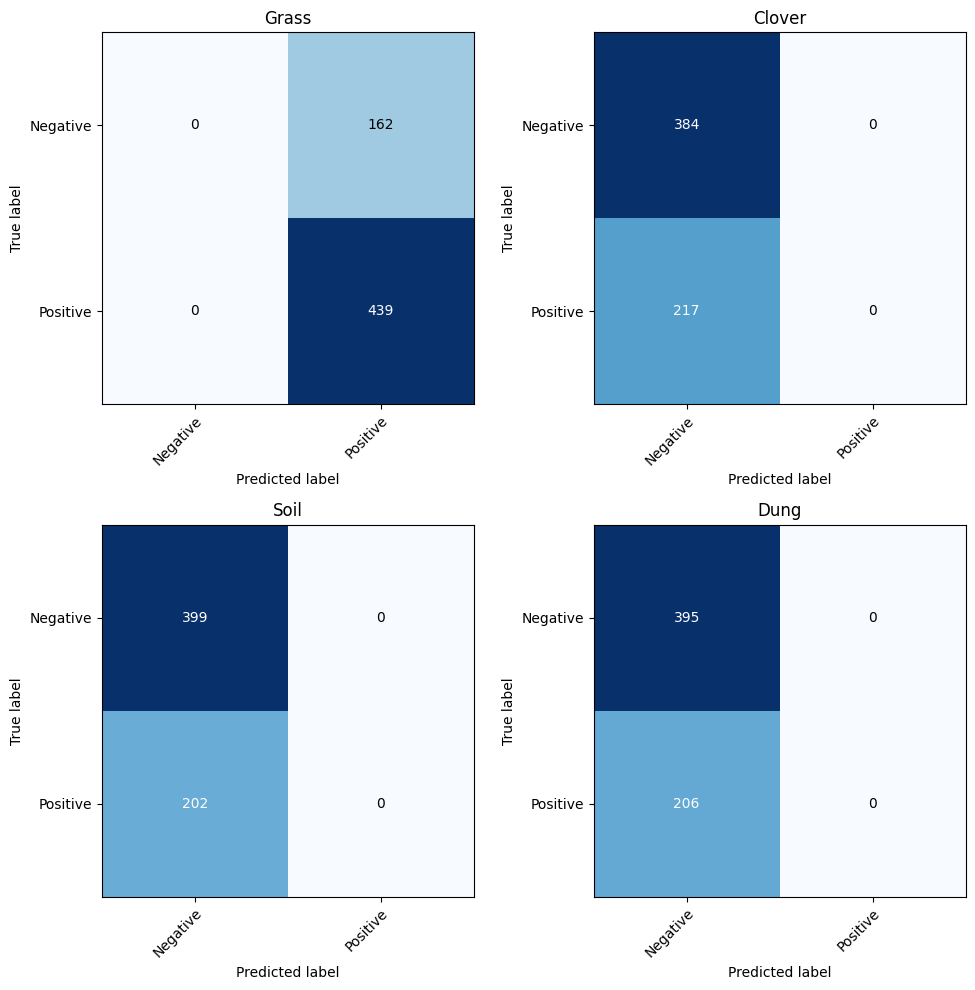

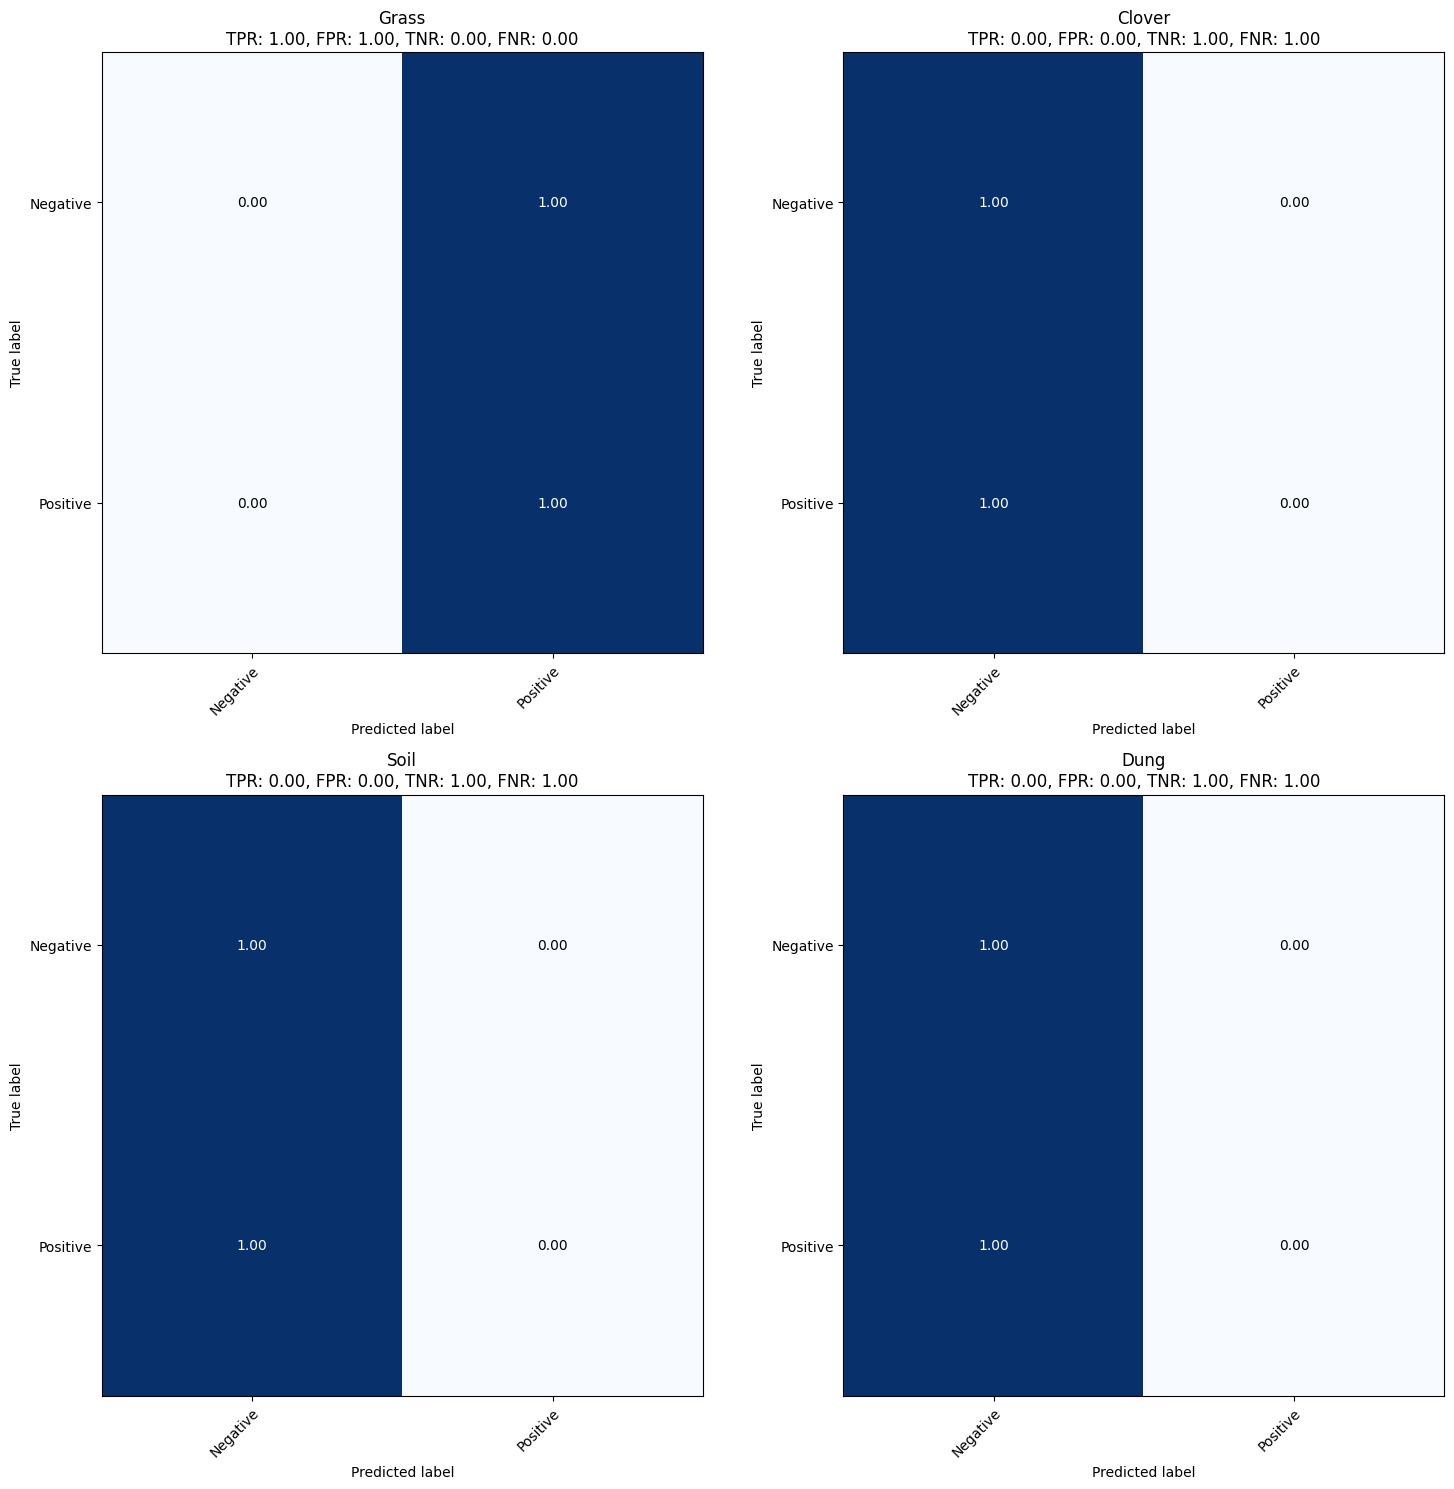

In [38]:
# Confusion matrices for dropout20 resnet model

show_confusion(true_labels, label_map, dropout20_ResNet_predictions)